# Comparing Randomization Schemes

In [23]:
%matplotlib inline
from matplotlib import pyplot as plt
from lolopy.learners import RandomForestRegressor
from sklearn.ensemble import RandomForestRegressor as SKRFRegressor
from sklearn.datasets import load_boston
import numpy as np
import pandas as pd

## Load the data

In [24]:
header_names=["nRow", "noiseTrain", "noiseTest", "nBag", "jackknife", "recalibration", "rmse", "stdconf", "ucorr", "stdres"]
keys = ["nRow", "nBag", "jackknife", "recalibration", "noiseTrain", "noiseTest"]
metrics = ["rmse", "stdconf", "ucorr", "stdres"]
types = {}
    
def load_data(file):
    df = pd.read_csv(file, header=None, names=header_names, dtype=types)
    grouped = df.groupby(by=keys, as_index=False)
    ans = grouped.mean()
    ans["count"] = grouped.count()[metrics[0]]
    for prop in metrics:
        ans["{} SEM".format(prop)] = np.sqrt(grouped.var()[prop] / (grouped.count()[prop] - 1))
    return ans

dat = load_data("full_data.csv")
avg_corr_jackknife = dat[dat["jackknife"]]["ucorr"].mean()
avg_corr_ensemble = dat[dat["jackknife"] != True]["ucorr"].mean()
print(avg_corr_ensemble, avg_corr_jackknife, avg_corr_ensemble - avg_corr_jackknife)

0.4193549122825911 0.37300208900549126 0.04635282327709983


In [64]:
def make_lc(df, training_noise=0.0, scaling=0, nRow=None):
    fig, axs = plt.subplots(4, 2)
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

    if nRow == None:
        x = "nRow"
    else:
        x = "nBag"
    
    def extract(sub):
        jk = sub[(sub["jackknife"]) & (sub["recalibration"])]
        es = sub[(sub["jackknife"] != True) & (sub["recalibration"])]
        jk_raw = sub[(sub["jackknife"]) & (sub["recalibration"] != True)]
        return jk, es, jk_raw
        
    def single_plot(ax, jk, es, jk_raw, metric):
        ax.set_xscale('log')

        ax.errorbar(jk[x], jk[metric], yerr=jk[metric + " SEM"], fmt="o-", label="Jackknife+Bias", color=colors[0])
        ax.errorbar(es[x], es[metric], yerr=es[metric + " SEM"], fmt="o-", label="Bootstrap", color=colors[1])
        # ax.errorbar(jk_raw[x], jk_raw[metric], yerr=jk_raw[metric + " SEM"], fmt="o--", label="JK+Bias", color=colors[0])
    
    if scaling > 0:
        df = df[(df["nRow"] * scaling == df["nBag"])]
    else:
        if nRow == None:
            df = df[(df["nBag"] == 128)]
        else:
            df = df[(df["nRow"] == nRow)]
    
    sub_pred = df[(df["noiseTrain"] == training_noise) & (df["noiseTest"] == training_noise)].sort_values(by=x)
    sub_conf = df[(df["noiseTrain"] == training_noise) & (df["noiseTest"] == 0.0)].sort_values(by=x)

    jk, es, jk_raw = extract(sub_conf)
    #print(sub_pred)

    single_plot(axs[0][0], jk, es, jk_raw, "rmse")
    single_plot(axs[1][0], jk, es, jk_raw, "stdconf")
    single_plot(axs[2][0], jk, es, jk_raw, "ucorr")
    single_plot(axs[3][0], jk, es, jk_raw, "stdres")
    axs[0][0].legend()
    axs[0][0].set_yscale("log")
    axs[0][0].set_title("Confidence")

    jk, es, jk_raw = extract(sub_pred)
    
    single_plot(axs[0][1], jk, es, jk_raw, "rmse")
    single_plot(axs[1][1], jk, es, jk_raw, "stdconf")
    single_plot(axs[2][1], jk, es, jk_raw, "ucorr")
    single_plot(axs[3][1], jk, es, jk_raw, "stdres")
    axs[0][1].set_yscale("log")
    axs[0][1].set_title("Prediction")
    
    axs[0][0].set_ylabel("RMSE")
    axs[1][0].set_ylabel("Standard Confidence")
    axs[2][0].set_ylabel("Uncertainty Correlation")
    axs[3][0].set_ylabel("Standard RMSE")
    axs[3][0].set_xlabel(x)
    axs[1][0].plot([16, max(es[x])], [0.68, 0.68], 'k--')
    axs[1][1].plot([16, max(es[x])], [0.68, 0.68], 'k--')
    axs[3][0].plot([16, max(es[x])], [1.0, 1.0], 'k--')
    axs[3][1].plot([16, max(es[x])], [1.0, 1.0], 'k--')
    

    rmse_min = df["rmse"].min()
    rmse_max = df["rmse"].max()
    for ax in axs[0]:
        ax.set_ylim(rmse_min*0.8, rmse_max*1.2)
    for ax in axs[1]:
        ax.set_ylim(0.6, 1.0)
    for ax in axs[2]:
        ax.set_ylim(0.0, 1.1)
    for ax in axs[3]:
        ax.set_ylim(0.0, 1.5)
    
    fig.set_size_inches(12, 9)
    fig.tight_layout()
    return fig

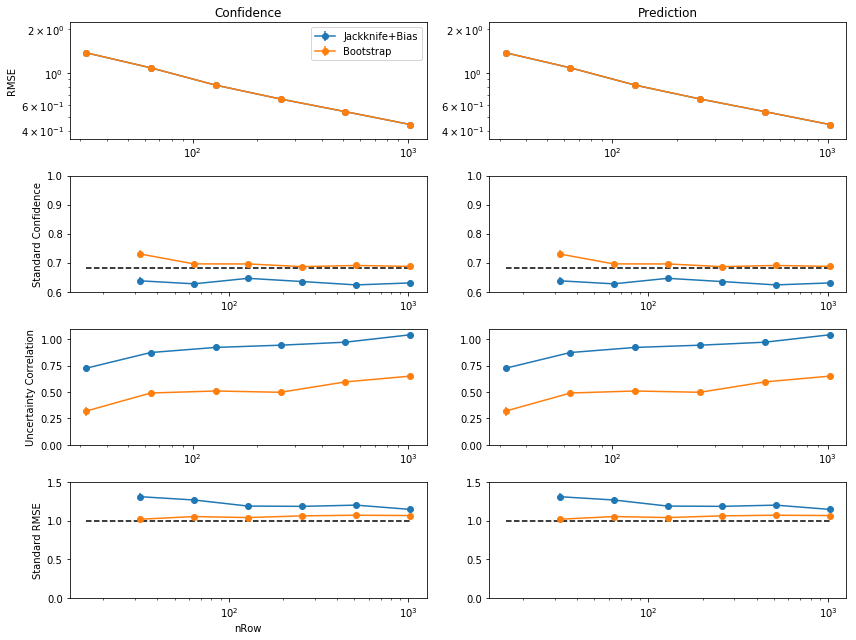

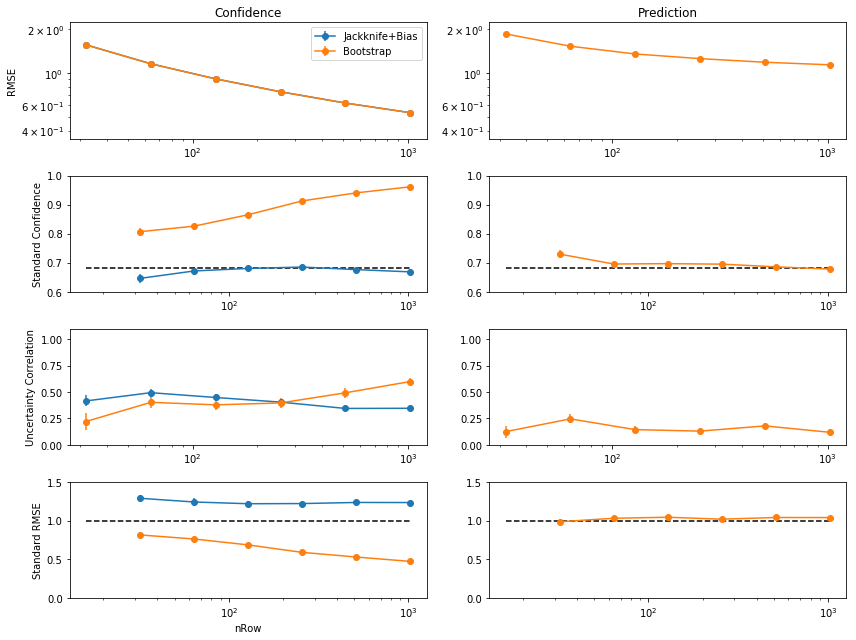

In [65]:
fig = make_lc(load_data("foo.csv"), training_noise=0.0, scaling=1)
fig.savefig("final-no-noise.svg")
fig = make_lc(load_data("foo.csv"), training_noise=1.0, scaling=1)
fig.savefig("final-with-noise.svg")
#load_data("no_floor_data.csv")

In [49]:
load_data("foo.csv")

,nRow,nBag,jackknife,recalibration,noiseTrain,noiseTest,rmse,stdconf,ucorr,stdres,count,rmse SEM,stdconf SEM,ucorr SEM,stdres SEM
0,16,32,False,True,0.000,0.000,1.825225,0.675842,0.304504,1.121039,64,0.037033,0.019428,0.042357,0.052133
1,16,32,False,True,0.125,0.000,1.842776,0.678222,0.268382,1.138346,32,0.054783,0.030729,0.076556,0.094589
2,16,32,False,True,0.125,0.125,1.848718,0.676758,0.263572,1.142166,32,0.054607,0.030662,0.076547,0.094427
3,16,32,False,True,0.250,0.000,1.852654,0.661415,0.268062,1.164920,31,0.056980,0.028846,0.081667,0.078889
4,16,32,False,True,0.250,0.250,1.872328,0.653099,0.246837,1.178647,31,0.056426,0.028394,0.076752,0.079165
5,16,32,False,True,0.500,0.000,1.881169,0.682019,0.319833,1.070713,31,0.059310,0.025203,0.071155,0.071111
6,16,32,False,True,0.500,0.500,1.954533,0.665260,0.293058,1.115884,31,0.057280,0.025178,0.070604,0.071660
7,16,32,False,True,1.000,0.000,1.959014,0.702055,0.250695,1.005976,31,0.062630,0.026023,0.072465,0.052541
8,16,32,False,True,1.000,1.000,2.213113,0.649256,0.174983,1.146490,31,0.056709,0.023898,0.063661,0.057183
9,16,32,True,True,0.000,0.000,1.825225,0.495240,0.460226,1.834647,64,0.037033,0.013466,0.032369,0.071769
